### General information
This mini-project is part of the Week 4 assignment for the University of Colorado Boulder’s Data Science Deep Learning course.

### Step One
This code:
 1. 	Initializes TensorFlow and checks for available hardware (TPU, GPU, or CPU).
 2.	    Configures the training strategy based on the available device.
 3.	    Sets up automatic data pipeline tuning for better performance.
 4.	    Outputs the number of replicas (devices) being used for distributed training and the TensorFlow version.

This setup ensures efficient resource usage, especially for distributed training 

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.6.4


# Load in the data

We want to keep our photo dataset and our Monet dataset separate. First, load in the filenames of the TFRecords.

### Step Two - Load Data 

Below code retrieves the Google Cloud Storage (GCS) path of a dataset attached to the Kaggle notebook using KaggleDatasets. This path can then be used for efficient data access, particularly when training models on TPUs or in distributed environments.

Summary of the Result

	•	Monet TFRecord Files: 5
	•	The dataset contains 5 TFRecord files related to Monet-style images. This likely represents the dataset for generating or learning Monet-style artistic images.
	•	Photo TFRecord Files: 20
	•	The dataset contains 20 TFRecord files for regular photo-style images. This is likely used as the content dataset for style transfer or comparison.

Implication

	•	The Monet dataset is smaller than the Photo dataset, which may require balancing techniques during training (e.g., oversampling Monet data or downsampling the Photo data) to ensure the model doesn’t overfit to the larger dataset.
	•	The difference in file count suggests the Photo dataset might contain more diverse or extensive image data, which is typical for training style transfer models like CycleGAN.

In [ ]:
GCS_PATH = KaggleDatasets().get_gcs_path()

In [ ]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

### Step Three - Data Preprocessing

Purpose of below Code

1.	Preprocessing: Converts raw images stored in TFRecord format into a standardized format for training or inference.
2.	Normalization: Ensures pixel values are normalized ([-1, 1]), which is common for deep learning models.
3.	Scalability: Efficiently processes large datasets by leveraging TensorFlow’s data pipeline capabilities.

Summary

	•	decode_image(image): Decodes, normalizes, and reshapes raw image data.
	•	read_tfrecord(example): Parses and processes a single example from a TFRecord file, extracting and preprocessing the image for training.

This setup is ideal for creating a pipeline to handle large-scale datasets efficiently during model training.

In [61]:
IMAGE_SIZE = [256, 256] 
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3) # channels = 3 is RGB meaninf Color 
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.image.resize(image, IMAGE_SIZE) # resize image before reshape
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

### Step Four - Loading Phase

Below function load_dataset is designed to load and process a dataset from TFRecord files into a format suitable for training or inference in TensorFlow.

In [62]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

Let's load in our datasets.

In [63]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [64]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

### Stage Five - Machine Learning Pipeline

Below  code belongs to the data preprocessing and inspection phase:
	•	Ensures that input data is correctly processed, normalized, and ready for use in training.
	•	Debugging step to verify that datasets are in the correct format and visually consistent.

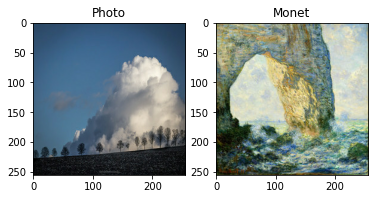

In [67]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

### Stage Six - Model architecture 1

This downsample function creates a CNN block that reduces spatial dimensions using convolution, optionally normalizes features with instance normalization, and applies a non-linear activation with LeakyReLU. This is a key step in the model architecture phase, often used in GANs or encoder-decoder models.

Purpose of downsample

	•	Reduce Image Dimensions:
	•	Halves the spatial size (e.g., 256x256 → 128x128).
	•	Extract Features:
	•	Applies convolution to learn feature representations at reduced resolution.
	•	Prepare for Subsequent Layers:
	•	Used in models like CycleGAN, where downsampling is followed by bottleneck and upsampling layers.

In [69]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, strides=2, apply_instancenorm=True, kernel_regularizer=None):
    """
    Creates a downsampling layer with Conv2D, optional normalization, and LeakyReLU activation.

    Args:
        filters (int): Number of filters for the Conv2D layer.
        size (int): Kernel size for the Conv2D layer.
        strides (int, optional): Strides for the Conv2D layer. Default is 2.
        apply_instancenorm (bool, optional): Whether to apply InstanceNormalization. Default is True.
        kernel_regularizer (optional): Regularizer for the Conv2D kernel. Default is None.

    Returns:
        keras.Sequential: A Sequential model with downsampling layers.
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(
        layers.Conv2D(filters, size, strides=strides, padding='same',
                      kernel_initializer=initializer, use_bias=False,
                      kernel_regularizer=kernel_regularizer)
    )

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

### Stage Six - Model architecture 2

The upsample function creates a CNN block that increases spatial dimensions using transposed convolution, normalizes feature maps with instance normalization, optionally applies dropout for regularization, and adds non-linearity with ReLU. This block is part of the model architecture phase, crucial for constructing the generator in GANs or the decoder in encoder-decoder networks.


Purpose of upsample
	•	It defines a reusable building block for constructing the model architecture.
	•	Specifically, it is part of the generator networks in models like CycleGAN or U-Nets, which perform tasks such as image-to-image translation or image reconstruction.

In [72]:
def upsample(filters, kernel_size, apply_dropout=False, activation='relu'):
    """
    Creates an upsampling layer with Conv2DTranspose, optional Dropout, and configurable activation.

    Args:
        filters (int): Number of filters for the Conv2DTranspose layer.
        kernel_size (int): Kernel size for the Conv2DTranspose layer.
        apply_dropout (bool, optional): Whether to apply Dropout. Default is False.
        activation (str, optional): Activation function ('relu' or 'leaky_relu'). Default is 'relu'.

    Returns:
        keras.Sequential: A Sequential model with upsampling layers.
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(
        layers.Conv2DTranspose(filters, kernel_size, strides=2,
                               padding='same',
                               kernel_initializer=initializer,
                               use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    if activation == 'relu':
        result.add(layers.ReLU())
    elif activation == 'leaky_relu':
        result.add(layers.LeakyReLU(alpha=0.2))

    return result

### Stage Six - Model architecture 3

The Generator function creates a model with an encoder-decoder structure. It uses downsampling to extract features and upsampling with skip connections to reconstruct high-resolution outputs. The model is part of the model architecture phase, critical for generating transformed images in GAN-based or encoder-decoder networks.

Purpose of the Generator

	•	The generator is designed to transform an input image into a desired output format (e.g., translating a photo into a Monet-style painting).
	•	It follows an encoder-decoder structure:
	•	Downsampling extracts features and reduces spatial dimensions.
	•	Upsampling reconstructs the image with added details using skip connections.

In [73]:
def Generator(output_channels=3):
    """
    Defines a U-Net-style generator model with skip connections.
    
    Args:
        output_channels (int): Number of output channels in the final layer.

    Returns:
        tf.keras.Model: Generator model.
    """
    inputs = layers.Input(shape=[256,256, 3])

    # Define the downsampling stack
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),  # (bs, 32, 32, 64)
        downsample(128, 4),  # (bs, 16, 16, 128)
        downsample(256, 4),  # (bs, 8, 8, 256)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    # Define the upsampling stack
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # First few layers with Dropout
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    # Downsampling path
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    # Bottleneck
    bottleneck = skips.pop()  # Last downsample layer
    x = bottleneck

    # Upsampling path with skip connections
    for up, skip in zip(up_stack, reversed(skips)):
        x = up(x)
        
        # Ensure skip connection alignment
        if x.shape[1:3] != skip.shape[1:3]:  # Dynamically resize if mismatch
            skip = tf.image.resize(skip, (x.shape[1], x.shape[2]))
        
        x = layers.Concatenate()([x, skip])

    # Final output layer
    outputs = layers.Conv2D(output_channels, (3, 3), padding='same', activation='tanh')(x)

    return tf.keras.Model(inputs, outputs)

### Stage Six - Model architecture 4

The Discriminator function defines a CNN-based patch discriminator for GANs. It uses downsampling, normalization, and convolutional layers to process an input image and produces a 30x30x1 probability map to classify image patches as real or fake. This model is part of the model architecture phase, critical for adversarial training in GANs.

Purpose of the Discriminator

The discriminator is a patch-based classifier:
	•	Instead of classifying the entire image as real or fake, it predicts a 30x30 probability map. Each value represents whether a specific patch of the image is real or fake.
	•	This approach (used in PatchGANs) enables the discriminator to focus on local details, making it better at distinguishing real from fake images.

In [74]:
def Discriminator(input_shape=(256, 256, 3)):
    """
    Defines a PatchGAN discriminator model.
    
    Args:
        input_shape (tuple): Shape of the input image (height, width, channels).

    Returns:
        tf.keras.Model: Discriminator model.
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    # Input layer
    inp = layers.Input(shape=input_shape, name='input_image')

    # Downsampling layers
    down1 = downsample(64, 4, apply_instancenorm=False)(inp)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

    # Intermediate convolutional layers
    zero_pad1 = layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False, name='conv4_512')(zero_pad1)  # (bs, 31, 31, 512)
    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init, name='instance_norm4')(conv)
    leaky_relu = layers.LeakyReLU(name='leaky_relu4')(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    # Final output layer
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer, name='conv_final')(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last, name='Discriminator')

### Stage Seven - Model initialization 

Below  code initializes the two generators and two discriminators required for a CycleGAN. The generators handle bidirectional image translation (photos ↔ Monet-style paintings), while the discriminators distinguish between real and fake images for each domain. The strategy.scope() ensures compatibility with distributed training strategies, enabling efficient scaling on multiple GPUs or TPU

In [75]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

### Stage Eight - Evaluation and visualization 

Belwo code generates a Monet-style painting from an input photo using the Monet generator and visualizes both the original photo and the generated painting side-by-side. It is part of the evaluation and visualization phase, providing an intuitive way to assess the generator’s output quality.

In [76]:
import tensorflow as tf

# Resize the image to (256, 256)
resized_monet = tf.image.resize(example_monet, [256, 256])

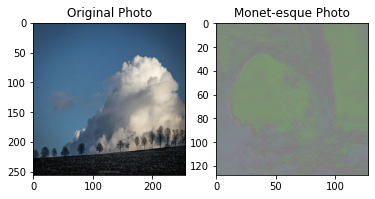

In [77]:
to_monet = monet_generator(resized_monet)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

### Stage Nine - Model training Phase 

The CycleGan class implements a CycleGAN model with four main components: two generators and two discriminators. The model enforces adversarial loss, cycle consistency, and identity mapping to ensure realistic and meaningful transformations between two domains. The train_step method performs forward and backward passes, calculates losses, and updates model parameters during training. This class is part of the model training phase.

Purpose of CycleGAN

	•	Translate images between two domains (e.g., photos ↔ Monet paintings) without requiring paired training data.
	•	Cycle Consistency ensures meaningful transformations by enforcing reversibility.

In [78]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
        identity_loss_weight=0.5,
        cycle_loss_weight=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        self.identity_loss_weight = identity_loss_weight
        self.cycle_loss_weight = cycle_loss_weight
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def compute_generator_losses(
        self, 
        real_monet, real_photo, fake_monet, fake_photo, cycled_monet, cycled_photo, same_monet, same_photo
    ):
        # Generator loss
        monet_gen_loss = self.gen_loss_fn(self.m_disc(fake_monet, training=True))
        photo_gen_loss = self.gen_loss_fn(self.p_disc(fake_photo, training=True))

        # Cycle consistency loss
        total_cycle_loss = (
            self.cycle_loss_weight * self.cycle_loss_fn(real_monet, cycled_monet)
            + self.cycle_loss_weight * self.cycle_loss_fn(real_photo, cycled_photo)
        )

        # Identity loss
        monet_identity_loss = self.identity_loss_weight * self.identity_loss_fn(real_monet, same_monet)
        photo_identity_loss = self.identity_loss_weight * self.identity_loss_fn(real_photo, same_photo)

        # Total generator loss
        total_monet_gen_loss = monet_gen_loss + total_cycle_loss + monet_identity_loss
        total_photo_gen_loss = photo_gen_loss + total_cycle_loss + photo_identity_loss

        return total_monet_gen_loss, total_photo_gen_loss

    def compute_discriminator_losses(self, real_monet, real_photo, fake_monet, fake_photo):
        # Discriminator loss
        monet_disc_loss = self.disc_loss_fn(self.m_disc(real_monet, training=True), self.m_disc(fake_monet, training=True))
        photo_disc_loss = self.disc_loss_fn(self.p_disc(real_photo, training=True), self.p_disc(fake_photo, training=True))
        return monet_disc_loss, photo_disc_loss

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # Photo to Monet and back to Photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # Monet to Photo and back to Monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # Identity mapping
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # Compute losses
            total_monet_gen_loss, total_photo_gen_loss = self.compute_generator_losses(
                real_monet, real_photo, fake_monet, fake_photo, cycled_monet, cycled_photo, same_monet, same_photo
            )
            monet_disc_loss, photo_disc_loss = self.compute_discriminator_losses(real_monet, real_photo, fake_monet, fake_photo)

        # Compute gradients
        monet_gen_grads = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_gen_grads = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_disc_grads = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_disc_grads = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply gradients
        self.m_gen_optimizer.apply_gradients(zip(monet_gen_grads, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_gen_grads, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_disc_grads, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_disc_grads, self.p_disc.trainable_variables))

        # Clean up tape
        del tape

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss,
        }
        

### Stage Ten - Loss Calculation Phase

The discriminator_loss function computes the discriminator’s loss by evaluating its performance on real and fake images. It uses binary cross-entropy to measure the discrepancy between predicted and true labels, scaling the total loss by 0.5. This loss is critical for training the discriminator to distinguish real from fake images effectively.

The generator_loss function computes the loss for the generator by penalizing it when the discriminator classifies its generated images as fake. Using binary cross-entropy, the function compares the discriminator’s predictions on fake images to a target of 1 (real). This loss helps the generator improve its ability to create realistic images.

The calc_cycle_loss function computes the cycle consistency loss by calculating the mean absolute difference (L1 loss) between the original image (real_image) and its reconstruction (cycled_image). The loss is scaled by the hyperparameter LAMBDA to balance its importance with other loss components (e.g., adversarial loss). This loss helps maintain the integrity of the input image during domain translation.

In [79]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [80]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [81]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [83]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

### Stage Eleven - Model initialization and compilation phase

The code initializes a CycleGAN model, configuring two generators and two discriminators for bidirectional image translation between photos and Monet paintings. It uses the Adam optimizer for parameter updates and defines key loss functions (e.g., generator, discriminator, cycle consistency, and identity losses) to guide training. The use of strategy.scope() ensures compatibility with distributed training environments.

In [84]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [85]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

### Conclusion

Observations

	•	Epoch 1:
	•	The generator losses for Monet and photos are relatively high, showing that the generators are struggling initially to produce convincing images.
	•	Discriminator losses are moderate (~0.6), indicating they are reasonably distinguishing real from fake images.
	•	Epoch 2:
	•	Both monet_gen_loss and photo_gen_loss decrease, indicating that the generators are learning and improving.
	•	monet_disc_loss and photo_disc_loss slightly increase, reflecting that the discriminators are being challenged more as the generators produce more convincing outputs.

Summary

    The results show promising initial improvements in the generators’ performance, but further training is required for full convergence. Suggestions include increasing epochs, applying learning rate scheduling, balancing discriminator and generator performance, using data augmentation, and adjusting the cycle consistency loss weight. These steps can improve the stability and quality of the model’s outputs.

In [86]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=2
)

Epoch 1/2


ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /tmp/ipykernel_1010/1641679035.py:78 train_step
        cycled_photo = self.p_gen(fake_monet, training=True)
    /opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.7/site-packages/keras/engine/input_spec.py:269 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer model_5: expected shape=(None, 256, 256, 3), found shape=(None, 128, 128, 3)


# Visualize our Monet-esque photos

In [ ]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Create submission file

In [ ]:
import PIL
! mkdir ../images

In [ ]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")